# Discovering genetic patterns of liver cancer  - Unsupervised Approach

### TL;DR
We discussed in our first notebook that liver cancer has the second highest mortality rate. Hence, we have explored and analyzed the publicly-available liver cancer dataset to identify candidate biomarkers related to disease progression using common bioinformatic Python and R toolkits. 

### Introduction
This notebook focuses on applying an unsupervised clustering approach to identify the underlying patterns between the RNA-Seq data representing the hallmarks of cancer and liver cancer progression (i.e. tumor stage). An unsupervised learning approach helps uncover structure within data to establish relationships without any previously assigned labels. We would also be exploring the hypothesis that an association exists between patient's cluster membership derived from gene expression data and patients' liver cancer stage. To validate this hypothesis, we have followed the following machine learning pipeline and established our conclusion.

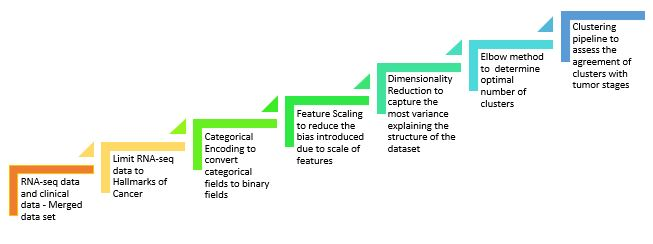

##### Load libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import preprocessing 
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

##### Set variables

In [25]:
data_dir=""
rnaseq_file=data_dir+"./data/lihc_rnaseq.csv.gz"
clinical_file=data_dir+"./data/revised_clinical.tsv"

### Data loading and cleaning

##### RNA Seq Data

In [26]:
rnaseq = (pd.
          read_csv(rnaseq_file,compression="gzip").
          set_index('bcr_patient_barcode').
          applymap(lambda x : int(np.ceil(x)))
         )
display(rnaseq.shape)
display(rnaseq.head())

(423, 20531)

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,0,2,4,91,1018,0,142,1,0,0,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,0,27,3,72,640,0,123,2,0,0,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,0,0,5,96,743,0,96,2,1,0,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,0,6,6,62,1187,0,281,1,0,0,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,0,12,6,105,879,0,283,0,0,0,...,42,1000,1632,5,1381,2903,576,666,3,120


In [27]:
gene_name_logical = [len(x[0])>1 for x in rnaseq.columns.str.split('|')]
sub = rnaseq.loc[:,gene_name_logical]
sub.columns = [x[0] for x in sub.columns.str.split('|')]
rnaseq_sub = sub.copy()
rnaseq_sub.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,22283,584,0,375,0,286320,81,543,1,1032,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,22642,1573,3,99,0,31169,163,2,1,903,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,77670,1281,0,215,1,19515,119,1,3,773,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,9323,1253,0,2914,2,243941,72,0,0,722,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,84243,1641,0,404,0,8756,83,0,9,828,...,42,1000,1632,5,1381,2903,576,666,3,120


In [28]:
rnaseq_sub.index = rnaseq_sub.index.map(lambda x: '-'.join(x.split('-')[:3]).lower())
print(rnaseq_sub.shape)
rnaseq_sub.head()

(423, 20501)


,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s,22283,584,0,375,0,286320,81,543,1,1032,...,25,274,795,19,500,3173,891,511,4,7
tcga-2y-a9gs,22642,1573,3,99,0,31169,163,2,1,903,...,69,633,1154,72,1001,5302,756,861,7,483
tcga-2y-a9gt,77670,1281,0,215,1,19515,119,1,3,773,...,47,1220,1134,13,1290,3220,861,524,15,84
tcga-2y-a9gu,9323,1253,0,2914,2,243941,72,0,0,722,...,19,286,1151,10,942,3093,1340,344,3,3
tcga-2y-a9gv,84243,1641,0,404,0,8756,83,0,9,828,...,42,1000,1632,5,1381,2903,576,666,3,120


### Using only the genes from the hallmarks of cancer

Here, we would be using the hallmarks of cancer geneset dictionary pickle file to limit the RNA gene expressions of patients only to those genes that are representative of the hallmarks of cancer. We ended up restricting our research from 20k+ gene expressions to around 4k+ which will probably have higher correlation with liver cancer stages. 

In [29]:
geneset_dict = pickle.load(open('hallmarks_of_cancer_geneset_dictionary.pkl','rb'))

In [30]:
all_hallmark_genes = np.unique(np.concatenate([v for k,v in geneset_dict.items()]))
len(all_hallmark_genes)

4384

In [31]:
rnaseq_sub = rnaseq_sub.loc[:,np.intersect1d(rnaseq_sub.columns.values,all_hallmark_genes)]
print(rnaseq_sub.shape)
rnaseq_sub.head()

(423, 4223)


,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRD1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s,286320,1032,25,7024,1535,1151,1678,93,109,1219,...,4,489,505,1712,639,0,0,305,464,3173
tcga-2y-a9gs,31169,903,156,8495,11220,1249,1126,74,50,1079,...,3,485,174,1347,348,0,0,677,629,5302
tcga-2y-a9gt,19515,773,479,3542,12577,3133,2186,70,25,2316,...,1,412,141,1564,260,0,0,399,287,3220
tcga-2y-a9gu,243941,722,36,5918,9671,1748,246,452,14,1269,...,1,332,106,626,237,0,0,433,451,3093
tcga-2y-a9gv,8756,828,616,6088,23069,2885,1129,110,39,2132,...,2,347,124,1320,339,0,0,642,100,2903


#### Clinical 

In [32]:
clinical = pd.read_csv(clinical_file, sep='\t')
clinical['submitter_id'] = clinical['submitter_id'].map(lambda x: x.lower())
clinical.head()

,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,ethnicity,vital_status,days_to_death,...,treatment_effect,initial_disease_status,treatment_type,therapeutic_agents,regimen_or_line_of_therapy,treatment_intent_type,treatment_anatomic_site,treatment_outcome,days_to_treatment_end,treatment_or_therapy
0,bce25281-502e-4599-9679-32dc8462ffb1,tcga-dd-a4ne,TCGA-LIHC,female,1936,white,-27549,hispanic or latino,Dead,660.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
1,654af137-70d9-4ee4-9f69-793e352d30f8,tcga-dd-a1ee,TCGA-LIHC,male,1933,white,-26858,not hispanic or latino,Dead,349.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
2,45f00f00-d793-4dca-aeb9-7626d4575c90,tcga-gj-a9db,TCGA-LIHC,male,1945,white,-25020,not hispanic or latino,Dead,67.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
3,496beef9-80d9-4734-a23d-334ae1b6aaab,tcga-dd-aac8,TCGA-LIHC,male,1936,asian,-26322,not hispanic or latino,Dead,16.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
4,d1aa9c1a-d732-48c0-b669-8a14e0397344,tcga-2y-a9gv,TCGA-LIHC,female,1953,white,-20011,not hispanic or latino,Dead,2532.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,yes


### Merge RNASeq data and Clinical data to validate the hypothesis

We merged the two datasets. We have included the demographic information like gender, race, ethnicity, etc and also tumor stage information for each patient available in the clinical data. We have also formatted tumor stage names to standardize the nomenclature. 

In [33]:
full_df_stage = pd.merge(rnaseq_sub.reset_index(), clinical[['submitter_id','gender','race','ethnicity','tumor_stage']], left_on='bcr_patient_barcode', right_on='submitter_id', how='inner') \
    .set_index('bcr_patient_barcode') \
    .drop('submitter_id', axis=1)

#ensuring ID uniqueness
full_df_stage.index = [x + '-' + str(i) for i,x in enumerate(full_df_stage.index)]
print(full_df_stage.shape)
full_df_stage.head()

(423, 4227)


,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNRD1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,gender,race,ethnicity,tumor_stage
tcga-2v-a95s-0,286320,1032,25,7024,1535,1151,1678,93,109,1219,...,639,0,0,305,464,3173,male,asian,not hispanic or latino,stage ii
tcga-2y-a9gs-1,31169,903,156,8495,11220,1249,1126,74,50,1079,...,348,0,0,677,629,5302,male,white,hispanic or latino,not reported
tcga-2y-a9gt-2,19515,773,479,3542,12577,3133,2186,70,25,2316,...,260,0,0,399,287,3220,male,white,not hispanic or latino,stage i
tcga-2y-a9gu-3,243941,722,36,5918,9671,1748,246,452,14,1269,...,237,0,0,433,451,3093,female,white,not hispanic or latino,stage i
tcga-2y-a9gv-4,8756,828,616,6088,23069,2885,1129,110,39,2132,...,339,0,0,642,100,2903,female,white,not hispanic or latino,stage i


In [34]:
# Subset out the recognizable stages
tumor_stages = clinical['tumor_stage'].value_counts()
tumor_stages[tumor_stages.index.str.startswith('stage')]

stage i       175
stage ii       87
stage iiia     65
stage iiib      9
stage iiic      9
stage iii       3
stage iv        2
stage ivb       2
stage iva       1
Name: tumor_stage, dtype: int64

In [35]:
# Subset full dataframe for patient samples that have a corresponding tumor stage
full_df_stage = full_df_stage.loc[full_df_stage['tumor_stage'].str.startswith('stage')]

# Since there are substages (eg, stage iia and stage iib), we will conver them to the 4 main stages
full_df_stage['tumor_stage'] = full_df_stage['tumor_stage'] \
                            .str.replace('a', '') \
                            .str.replace('b', '') \
                            .str.replace('c', '') \
                            .str.replace('v', '') \
                            .str.replace('stge','stage')
df_stage = full_df_stage.reset_index()
df_stage.head()

,index,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNRD1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,gender,race,ethnicity,tumor_stage
0,tcga-2v-a95s-0,286320,1032,25,7024,1535,1151,1678,93,109,...,639,0,0,305,464,3173,male,asian,not hispanic or latino,stage ii
1,tcga-2y-a9gt-2,19515,773,479,3542,12577,3133,2186,70,25,...,260,0,0,399,287,3220,male,white,not hispanic or latino,stage i
2,tcga-2y-a9gu-3,243941,722,36,5918,9671,1748,246,452,14,...,237,0,0,433,451,3093,female,white,not hispanic or latino,stage i
3,tcga-2y-a9gv-4,8756,828,616,6088,23069,2885,1129,110,39,...,339,0,0,642,100,2903,female,white,not hispanic or latino,stage i
4,tcga-2y-a9gw-5,43813,622,49,4758,7663,1649,2252,96,58,...,361,0,0,351,221,8467,male,white,not hispanic or latino,stage i


### Merged RNA Seq data with clinical demographic patient information for Clustering

We merged the two datasets. We have only extracted the demographic information available in clinical data of the patients. This merged dataset does not have any liver cancer stage information (any labels). We will use this data as an input to our clustering pipeline as shown below:  

In [36]:
# Merging demographic information like gender, race, ethnicity with gene expression data 
full_df = pd.merge(rnaseq_sub.reset_index(), clinical[['submitter_id','gender','race','ethnicity']], left_on='bcr_patient_barcode', right_on='submitter_id', how='inner') \
    .set_index('bcr_patient_barcode') \
    .drop('submitter_id', axis=1)
#ensuring ID uniqueness
full_df.index = [x + '-' + str(i) for i,x in enumerate(full_df.index)]
full_df.head()

,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNFX1,ZNRD1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,gender,race,ethnicity
tcga-2v-a95s-0,286320,1032,25,7024,1535,1151,1678,93,109,1219,...,1712,639,0,0,305,464,3173,male,asian,not hispanic or latino
tcga-2y-a9gs-1,31169,903,156,8495,11220,1249,1126,74,50,1079,...,1347,348,0,0,677,629,5302,male,white,hispanic or latino
tcga-2y-a9gt-2,19515,773,479,3542,12577,3133,2186,70,25,2316,...,1564,260,0,0,399,287,3220,male,white,not hispanic or latino
tcga-2y-a9gu-3,243941,722,36,5918,9671,1748,246,452,14,1269,...,626,237,0,0,433,451,3093,female,white,not hispanic or latino
tcga-2y-a9gv-4,8756,828,616,6088,23069,2885,1129,110,39,2132,...,1320,339,0,0,642,100,2903,female,white,not hispanic or latino


### One-Hot Encoding (Categorical Encoding):

As we see in the data frame obtained in previous step, there are some categorical fields like gender, race, ethnicity, etc. We one-hot encoded these categorical fields into new columns for use by our machine learning models.We see new fields like  gender_female, gender_male, race_asian, etc. below after this transformation. This is also called categorical encoding. The pandas' get_dummies function helps to perform this transformation

In [37]:
# One hot encoding on full dataframe to convert categorical fields into binary fields
full_df_onehot = pd.get_dummies(full_df, drop_first=False)
full_df_onehot.head()

,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,gender_female,gender_male,race_american indian or alaska native,race_asian,race_black or african american,race_not reported,race_white,ethnicity_hispanic or latino,ethnicity_not hispanic or latino,ethnicity_not reported
tcga-2v-a95s-0,286320,1032,25,7024,1535,1151,1678,93,109,1219,...,0,1,0,1,0,0,0,0,1,0
tcga-2y-a9gs-1,31169,903,156,8495,11220,1249,1126,74,50,1079,...,0,1,0,0,0,0,1,1,0,0
tcga-2y-a9gt-2,19515,773,479,3542,12577,3133,2186,70,25,2316,...,0,1,0,0,0,0,1,0,1,0
tcga-2y-a9gu-3,243941,722,36,5918,9671,1748,246,452,14,1269,...,1,0,0,0,0,0,1,0,1,0
tcga-2y-a9gv-4,8756,828,616,6088,23069,2885,1129,110,39,2132,...,1,0,0,0,0,0,1,0,1,0


###### Filtering those fields that are not required. 

In [38]:
# Filtering columns that are not required after one hot encoding 
full_df_onehot_filter = full_df_onehot.drop(['race_not reported','ethnicity_not reported','gender_male'],axis=1)
full_df_onehot_filter.head()

,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZW10,ZWINT,ZYX,gender_female,race_american indian or alaska native,race_asian,race_black or african american,race_white,ethnicity_hispanic or latino,ethnicity_not hispanic or latino
tcga-2v-a95s-0,286320,1032,25,7024,1535,1151,1678,93,109,1219,...,305,464,3173,0,0,1,0,0,0,1
tcga-2y-a9gs-1,31169,903,156,8495,11220,1249,1126,74,50,1079,...,677,629,5302,0,0,0,0,1,1,0
tcga-2y-a9gt-2,19515,773,479,3542,12577,3133,2186,70,25,2316,...,399,287,3220,0,0,0,0,1,0,1
tcga-2y-a9gu-3,243941,722,36,5918,9671,1748,246,452,14,1269,...,433,451,3093,1,0,0,0,1,0,1
tcga-2y-a9gv-4,8756,828,616,6088,23069,2885,1129,110,39,2132,...,642,100,2903,1,0,0,0,1,0,1


### Data Standardization & Scaling:

There are more than 4200+ RNA gene expressions and also more than 10 binary demographic fields that were obtained after one-hot 
encoding. Hene, these fields would have a huge range in the values. To eliminate this bias introduced due to scale differences
in the data, we have used min-max scaler for standardizing the entire dataset. This feature scaling approach maintains all the 
feature values between a standard range of 0 and 1.

In [39]:
# Transforming the data such that the features are within a specific range e.g. [0, 1]. - Feature Scaling  
x = full_df_onehot_filter #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
genome_clinic_df = pd.DataFrame(x_scaled,columns=full_df_onehot_filter\
            .loc[:, full_df_onehot_filter.columns != 'index'].columns)

In [40]:
index_df = full_df_onehot_filter.reset_index()
genome_clinic_std_concat = pd.concat([index_df['index'],genome_clinic_df],axis=1)
genome_clinic_std_concat.head()

,index,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZW10,ZWINT,ZYX,gender_female,race_american indian or alaska native,race_asian,race_black or african american,race_white,ethnicity_hispanic or latino,ethnicity_not hispanic or latino
0,tcga-2v-a95s-0,0.448328,0.303828,0.010175,0.420762,0.037160,0.112687,0.090351,0.032270,0.057489,...,0.305128,0.172026,0.187716,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,tcga-2y-a9gs-1,0.046382,0.242105,0.063492,0.526293,0.282823,0.123808,0.057453,0.025141,0.026371,...,0.782051,0.235955,0.326821,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,tcga-2y-a9gt-2,0.028023,0.179904,0.194953,0.170959,0.317243,0.337608,0.120627,0.023640,0.013186,...,0.425641,0.103448,0.190787,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,tcga-2y-a9gu-3,0.381567,0.155502,0.014652,0.341416,0.243532,0.180436,0.005006,0.166979,0.007384,...,0.469231,0.166990,0.182489,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,tcga-2y-a9gv-4,0.011075,0.206220,0.250712,0.353612,0.583376,0.309464,0.057632,0.038649,0.020570,...,0.737179,0.030996,0.170075,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [41]:
genome_clinic_std_concat.set_index('index', inplace=True)
genome_clinic_std_concat.head()

,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZW10,ZWINT,ZYX,gender_female,race_american indian or alaska native,race_asian,race_black or african american,race_white,ethnicity_hispanic or latino,ethnicity_not hispanic or latino
index,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s-0,0.448328,0.303828,0.010175,0.420762,0.037160,0.112687,0.090351,0.032270,0.057489,0.346594,...,0.305128,0.172026,0.187716,0.0,0.0,1.0,0.0,0.0,0.0,1.0
tcga-2y-a9gs-1,0.046382,0.242105,0.063492,0.526293,0.282823,0.123808,0.057453,0.025141,0.026371,0.304400,...,0.782051,0.235955,0.326821,0.0,0.0,0.0,0.0,1.0,1.0,0.0
tcga-2y-a9gt-2,0.028023,0.179904,0.194953,0.170959,0.317243,0.337608,0.120627,0.023640,0.013186,0.677215,...,0.425641,0.103448,0.190787,0.0,0.0,0.0,0.0,1.0,0.0,1.0
tcga-2y-a9gu-3,0.381567,0.155502,0.014652,0.341416,0.243532,0.180436,0.005006,0.166979,0.007384,0.361664,...,0.469231,0.166990,0.182489,1.0,0.0,0.0,0.0,1.0,0.0,1.0
tcga-2y-a9gv-4,0.011075,0.206220,0.250712,0.353612,0.583376,0.309464,0.057632,0.038649,0.020570,0.621760,...,0.737179,0.030996,0.170075,1.0,0.0,0.0,0.0,1.0,0.0,1.0


### Dimensionality Reduction with sparse PCA

The dataset obtained after above data transformations contains more than 4200+ features. This is a very high dimensional feature space. However, we need to focus on lower dimension representation of the feature space for K-Means Clustering to function accurately. Hence, we utilize dimensionality reduction technique. 

There are thousands of genes expressed in any given sample, but a patient may have very different genes expressed based on factors such as the tissue type, the sampling technique, and the time of sampling. This implies a lot of sparseness in the feature space among our samples. We have leveraged the sparse PCA module available in the scikit learn library in Python. This reduces the feature space of our dataset from 4200+ columns to 2 Principal Components that capture the most varience explaining the structure of the dataset.

In [42]:
# Dimensionality Reduction using Principal Component Analysis to reduce high dimension of 25k+ feature space into 10 significant featue space
n=2
pcs = ['PC'+str(x) for x in range(n)]
pca = SparsePCA(n_components=n,max_iter=20,n_jobs=4)
principalComponents = pca.fit_transform(genome_clinic_std_concat)
#print(pca.explained_variance_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = pcs)
principalDfConcat = pd.concat([index_df['index'],principalDf],axis=1)
principalDfConcat.head()

,index,PC0,PC1
0,tcga-2v-a95s-0,-0.062550,-0.021458
1,tcga-2y-a9gs-1,-0.055413,-0.039484
2,tcga-2y-a9gt-2,-0.035699,-0.067407
3,tcga-2y-a9gu-3,-0.043244,-0.056614
4,tcga-2y-a9gv-4,-0.035298,-0.061789


### K-Means Clustering:

K-Means Clustering is a popular clustering algorithm that segments data into K groups based on the underlying data patterns. We will apply scikit-learn's K-Means module for applying clustering algorithm on the principal components on the 2-dimensional representation of the data set. We have combined the cluster labels for each patient_id with the prinicpal components.

In [43]:
# Clustering Model building using KMeans and concatenating labels with the corresponding patient
#from scipy import stats

kmeans = KMeans(n_clusters=3, random_state=0).fit(principalDfConcat.set_index('index'))
labels = kmeans.labels_

#Glue back to original data
principalDfConcat['clusters'] = labels
cols = ['patient_id']
cols.extend(pcs)
cols.extend(['clusters'])
principalDfConcat.columns= cols
principalDfConcat.head()

,patient_id,PC0,PC1,clusters
0,tcga-2v-a95s-0,-0.062550,-0.021458,1
1,tcga-2y-a9gs-1,-0.055413,-0.039484,0
2,tcga-2y-a9gt-2,-0.035699,-0.067407,2
3,tcga-2y-a9gu-3,-0.043244,-0.056614,0
4,tcga-2y-a9gv-4,-0.035298,-0.061789,2


### Determining optimal number of clusters - Elbow Method:

The information on the best number of clusters,i.e. K needs to be known either by knowledge base or by Elbow method. We have approached the Elbow method to determine the best K clusters for our dataset. The Elbow Plot below does not display the exact structure of the data. However, the first bend is at K=3, which implies that it can be assumed to be the best chpice for the number of clusters. 

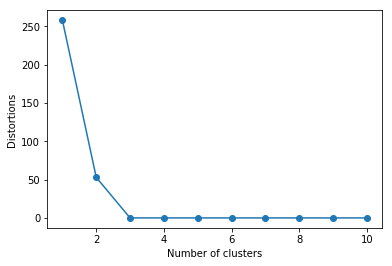

In [44]:
# Checking for best K when number of groups or clusters are not known - Used Elbow Plot. 

distortions = []
for k in range(1,11):
    kmeans = KMeans(
        n_clusters=k, init = "random",
        n_init=10, max_iter=300, random_state=0
    )
    kmeans.fit(principalDfConcat.set_index('patient_id'))
    distortions.append(kmeans.inertia_)
    
#plot
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.show()

As we see in the Elbow plot, we do not get exact elbow shape. However, the first bend is at k=3. We thus, assume 3 clusters would be appropriate count fo the number of clusters.

### Assessing similarity between cluster outcomes and the cancer stages provided in clinical data:

The clustering algorithm groups the patients into three groups 0,1 and 2, which represent the entire data. But, they still do not indicate the cancer stage information of the patient.

In [45]:
df_stage_valid = pd.merge(df_stage[['index','tumor_stage']], principalDfConcat[['patient_id','clusters']], right_on='patient_id', left_on='index', how='left') \
    .set_index('patient_id') \
    .drop('index', axis=1)
#ensuring ID uniqueness
df_stage_valid.index = [x + '-' + str(i) for i,x in enumerate(df_stage_valid.index)]
df_stage_valid.head()

,tumor_stage,clusters
tcga-2v-a95s-0-0,stage ii,1
tcga-2y-a9gt-2-1,stage i,2
tcga-2y-a9gu-3-2,stage i,0
tcga-2y-a9gv-4-3,stage i,2
tcga-2y-a9gw-5-4,stage i,0


We calculated the percentage of each cluster group and for each cancer stage to assess the initial hypothesis about the relationship between clusters representing the RNA gene expressions of the patients on one end and the liver cancer stages on the other end. We see how each representative cluster is spread across multiple cancer stages.

In [46]:
# Aggregating at clinical cancer stage level to check for similarity in both outcomes.
tmp = df_stage_valid.reset_index().groupby('tumor_stage')['clusters'].value_counts()
display(tmp)
(tmp/df_stage_valid.shape[0]).round(2)

tumor_stage  clusters
stage i      0           114
             1            44
             2            38
stage ii     0            41
             1            38
             2            19
stage iii    1            46
             0            30
             2            21
Name: clusters, dtype: int64

tumor_stage  clusters
stage i      0           0.29
             1           0.11
             2           0.10
stage ii     0           0.10
             1           0.10
             2           0.05
stage iii    1           0.12
             0           0.08
             2           0.05
Name: clusters, dtype: float64

As we can see from above results, tumor stage itself is not reflective of gene expression variation. Hence, we need to deep dive and understand which Hallmarks of cancer associate with each of the liver cancer stages in our next notebook.  